In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [2]:
###################
##### SET PARAMETERS
################### 
TICKER="DNA"
DATA_INTERVAL_MINUTES = 15   # (Set to 5 or 15)
DATA_AFTER_HOURS = False
###################
##### SET PARAMETERS
###################

In [3]:
import sys
sys.path.append('..\\..')

from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret_key("tiingo")

csv_data2020= tiingo.download_ticker(secret_key, TICKER, datetime(2020, 1, 1), datetime(2021,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2021= tiingo.download_ticker(secret_key, TICKER, datetime(2021, 1, 1), datetime(2022,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2022= tiingo.download_ticker(secret_key, TICKER, datetime(2022, 1, 1), datetime(2023,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 1, 1), datetime(2023,12,31), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023

Retrieving DNA from 2020-01-01 00:00:00 to 2021-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/DNA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2020-01-01&endDate=2021-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving DNA from 2021-01-01 00:00:00 to 2022-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/DNA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2021-01-01&endDate=2022-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving DNA from 2022-01-01 00:00:00 to 2023-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/DNA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2022-01-01&endDate=2023-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving DNA from 2023-01-01 00:00:00 to 2023-12-31 00:00:00 on 15m - https://api.tiingo.com/iex/DNA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2023-01-01&endDate=2023-12-31&resampleFreq=15min&afterHours=false&format=csv


'date,close,high,low,open,volume\n2023-01-03 09:30:00-05:00,1.76,1.795,1.7,1.705,9975.0\n2023-01-03 09:45:00-05:00,1.705,1.765,1.695,1.765,20569.0\n2023-01-03 10:00:00-05:00,1.645,1.71,1.635,1.705,17890.0\n2023-01-03 10:15:00-05:00,1.63,1.645,1.615,1.645,10880.0\n2023-01-03 10:30:00-05:00,1.605,1.625,1.6,1.625,19942.0\n2023-01-03 10:45:00-05:00,1.63,1.63,1.605,1.605,8423.0\n2023-01-03 11:00:00-05:00,1.605,1.625,1.605,1.625,13612.0\n2023-01-03 11:15:00-05:00,1.595,1.605,1.595,1.605,4284.0\n2023-01-03 11:30:00-05:00,1.59,1.595,1.58,1.595,9655.0\n2023-01-03 11:45:00-05:00,1.585,1.59,1.575,1.59,2028.0\n2023-01-03 12:00:00-05:00,1.585,1.585,1.58,1.585,836.0\n2023-01-03 12:15:00-05:00,1.575,1.585,1.555,1.585,10690.0\n2023-01-03 12:30:00-05:00,1.565,1.58,1.565,1.575,6347.0\n2023-01-03 12:45:00-05:00,1.565,1.565,1.555,1.565,9972.0\n2023-01-03 13:00:00-05:00,1.56,1.565,1.56,1.565,3375.0\n2023-01-03 13:15:00-05:00,1.56,1.565,1.55,1.565,15886.0\n2023-01-03 13:30:00-05:00,1.545,1.565,1.535,1.565,5

In [4]:
import io
import pandas as pd

df2020 = pd.read_csv(io.StringIO(csv_data2020))
df2021 = pd.read_csv(io.StringIO(csv_data2021))
df2022 = pd.read_csv(io.StringIO(csv_data2022))
df2023 = pd.read_csv(io.StringIO(csv_data2023))
if df2020.empty:
    print("2020 has nothing")
    df = pd.concat([df2021, df2022, df2023], axis=0, ignore_index=True)
else:
    print("Concatenating 2020")
    df = pd.concat([df2020, df2021, df2022, df2023], axis=0, ignore_index=True)


2020 has nothing


In [5]:
# Checks if ordered ascending

# Sort the DataFrame to check if it is in ascending order
df_sorted = df.sort_values("date")

# Check if the sorted DataFrame is equal to the original DataFrame
is_ascending = df_sorted.equals(df)

if is_ascending:
    print("The DataFrame is in ascending order.")
else:
    print("The DataFrame is not in ascending order.")


The DataFrame is in ascending order.


In [6]:
close_list = df['close'].astype(float).tolist()

print(f"df First: {df[:10]}")
print(f"close First: {close_list[:10]}")
print(f"df Last: {df[-10:]}")
print(f"close Last: {close_list[-10:]}")

df First:                         date  close   high    low   open  volume
0  2021-04-19 10:45:00-04:00  10.22  10.22  10.22  10.22   100.0
1  2021-04-19 11:00:00-04:00  10.18  10.18  10.11  10.11   400.0
2  2021-04-19 11:15:00-04:00  10.17  10.18  10.17  10.18   580.0
3  2021-04-19 11:30:00-04:00  10.17  10.17  10.17  10.17     0.0
4  2021-04-19 11:45:00-04:00  10.17  10.17  10.17  10.17     0.0
5  2021-04-19 12:00:00-04:00  10.17  10.17  10.17  10.17     0.0
6  2021-04-19 12:15:00-04:00  10.17  10.17  10.17  10.17     0.0
7  2021-04-19 12:30:00-04:00  10.17  10.17  10.17  10.17     0.0
8  2021-04-19 12:45:00-04:00  10.17  10.17  10.17  10.17     0.0
9  2021-04-19 13:00:00-04:00  10.17  10.17  10.17  10.17     0.0
close First: [10.22, 10.18, 10.17, 10.17, 10.17, 10.17, 10.17, 10.17, 10.17, 10.17]
df Last:                             date  close   high    low   open    volume
18289  2023-12-29 13:30:00-05:00  1.705  1.715  1.695  1.695    2738.0
18290  2023-12-29 13:45:00-05:00  1.705 

In [7]:
###################
##### SET PARAMETERS
###################
DAYS_PREDICT = 2
DOWN_PCTS_PREDICT= [5]
UP_PCTS_PREDICT= [7]
###################
##### SET PARAMETERS
###################

In [8]:

TICKS_IN_DAY = 26 if DATA_INTERVAL_MINUTES == 15 else 78
TICKS_PREDICT= TICKS_IN_DAY * DAYS_PREDICT

import classificators.series_classificator as classificator

classes_calc = classificator.SeriesClassificator(classificator.find_first_down_up, TICKS_PREDICT, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

classes= classes_calc.classify(close_list)
print(f"classes: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]}")
price_classes = [(pc[0], pc[1]) for pc in zip(close_list[2650:3000], classes[2650:3000])]
print(f"prices vs classes (window={TICKS_PREDICT}): {price_classes}")


classes: [0, nan]
prices vs classes (window=52): [(9.86, 1), (9.865, 1), (9.845, 1), (9.85, 1), (9.86, 1), (9.865, 1), (9.88, 1), (9.87, 1), (9.87, 1), (9.87, 1), (9.875, 1), (9.87, 1), (9.87, 1), (9.875, 1), (9.875, 1), (9.875, 1), (9.925, 1), (9.995, 1), (9.95, 1), (9.94, 1), (9.945, 1), (9.965, 1), (9.93, 1), (9.83, 1), (9.825, 0), (9.85, 0), (9.865, 0), (9.925, 0), (9.92, 0), (9.95, 0), (9.935, 0), (9.98, 0), (9.96, 0), (9.95, 0), (9.95, 0), (9.935, 0), (9.955, 0), (9.955, 0), (9.965, 0), (9.95, 0), (9.94, 0), (9.945, 0), (9.945, 0), (9.94, 0), (9.925, 0), (9.945, 0), (9.94, 0), (9.935, 0), (9.935, 0), (9.955, 0), (9.93, 0), (9.915, 0), (9.91, 0), (9.965, 0), (9.96, 0), (9.96, 0), (9.985, 0), (9.98, 0), (9.94, 0), (9.925, 0), (9.91, 0), (9.91, 0), (9.945, 0), (9.93, 0), (9.92, 0), (9.915, 0), (9.91, 0), (9.92, 0), (9.93, 0), (9.93, 0), (9.93, 0), (9.915, 0), (9.855, 0), (9.82, 0), (9.82, 0), (9.44, 2), (9.15, 2), (9.055, 2), (9.125, 2), (9.21, 2), (9.285, 2), (9.23, 2), (9.26, 2), 

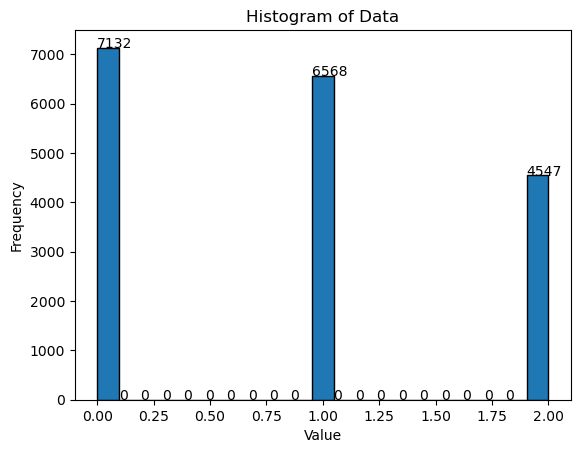

In [9]:
import matplotlib.pyplot as plt

# Create a histogram
hist_values, bin_edges, _ = plt.hist(classes, bins=21, edgecolor='black')

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display frequency on top of each bar
for value, edge in zip(hist_values, bin_edges[:-1]):
    plt.text(edge, value, str(int(value)), color='black')
    
# Show the histogram
plt.show()


In [10]:
import classificators.list_utils as lu


lu.display_frequency_numbers(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

Total: 18299
 35.89%   6568 times   0% change (1)
 38.97%   7132 times  -5% change (0)
 24.85%   4547 times   7% change (2)
  0.28%     52 times   0% change (nan)


In [11]:
###################
##### SET PARAMETERS
###################
signal_windows= [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]
###################
##### SET PARAMETERS
###################

In [24]:

import classificators.proportions_calc as proportions

signals_calculator = proportions.ProportionsCalc(signal_windows)

proportions_rolling_avg = signals_calculator.calculate(close_list)
print(f"rolling_avg: {proportions_rolling_avg[0][-10:]}")


rolling_avg: [0.0029325513196286268, -1.9534715975809204e-14, -1.9534715975809204e-14, -1.9534715975809204e-14, -0.0029498525073943494, -1.9780964804530812e-14, -1.9780964804530812e-14, -1.9780964804530812e-14, -1.9780964804530812e-14, -0.0029673590504650706]


In [25]:
print(len(close_list))
print(len(proportions_rolling_avg[len(signal_windows)-1]))

18299
18299


In [28]:
print(close_list[-10:])
print(proportions_rolling_avg[0][-10:])
current_sum = sum(close_list[-2:])/2
classes_len= len(classes)
signal_windows_len= len(signal_windows)

print(f"Signal windows: {signal_windows_len} Last length: {signal_windows[-1]}")
print(f"Classes last non-nan: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]} len: {classes_len}")
print(f"Proportions first non-nan: {proportions_rolling_avg[signal_windows_len-1][signal_windows[-1]-2:signal_windows[-1]]} len: {len(proportions_rolling_avg[signal_windows_len-1])}")
print(f"Proportions {signal_windows[0]} Min: {min(proportions_rolling_avg[0][signal_windows[0]-1:-TICKS_PREDICT-1])} Max: {max(proportions_rolling_avg[0][signal_windows[0]-1:-TICKS_PREDICT])}")
print(f"Proportions {signal_windows[-1]} Min: {min(proportions_rolling_avg[-1][signal_windows[-1]-1:-TICKS_PREDICT-1])} Max: {max(proportions_rolling_avg[-1][signal_windows[-1]-1:-TICKS_PREDICT])}")

[1.705, 1.705, 1.705, 1.705, 1.695, 1.695, 1.695, 1.695, 1.695, 1.685]
[0.0029325513196286268, -1.9534715975809204e-14, -1.9534715975809204e-14, -1.9534715975809204e-14, -0.0029498525073943494, -1.9780964804530812e-14, -1.9780964804530812e-14, -1.9780964804530812e-14, -1.9780964804530812e-14, -0.0029673590504650706]
Signal windows: 16 Last length: 2584
Classes last non-nan: [0, nan] len: 18299
Proportions first non-nan: [nan, 0.0010667620069820748] len: 18299
Proportions 2 Min: -0.08264462809917836 Max: 0.08449946178686112
Proportions 2584 Min: -2.162611895734038 Max: 0.40492674483802216


In [30]:
# Cutting from first non-nan in the signal_windows[-1] to last non-nan in the classes
targets = classes[signal_windows[-1]-1:-TICKS_PREDICT]
inputs = []
for proportion in proportions_rolling_avg:
    proportion_cut= proportion[signal_windows[-1]-1:-TICKS_PREDICT]
    print(proportion_cut[:2])
    inputs.append(proportion_cut)

print(f"First target: {targets[0]} and last target: {targets[-1]}")
print(f"Classes: {len(classes)} after cut to targets: {len(targets)}")
print(f"Inputs {len(inputs[len(signal_windows)-1])}")
print(f"Distinct targets: {list(set(targets))}")


[-1.067950003647445e-15, -1.067950003647445e-15]
[3.3818416782169095e-15, 3.3818416782169095e-15]
[-0.00020040080160540924, -2.13590000729489e-15]
[-0.0005010020040093402, -0.00037575150300745016]
[-0.0006551564667889754, -0.0005780792354032516]
[-0.00019085790629083202, -0.00021471514457683006]
[0.00020629494282539654, 0.00017682423670730476]
[0.0005465476407353424, 0.0005192202586986375]
[0.0007205422080100994, 0.0007036545000097945]
[0.0009219828545974838, 0.0009150244934305934]
[0.0010708111502064873, 0.0010557595878543562]
[0.001008648596935527, 0.0010113064325005213]
[0.0002004008015998915, 0.00018643845066879528]
[0.003177073498579978, 0.0031745354945070295]
[0.003088518928908605, 0.0030878914999742354]
[0.0010667620069820748, 0.0010760685457564339]
First target: 1 and last target: 0
Classes: 18299 after cut to targets: 15664
Inputs 15664
Distinct targets: [0, 1, 2]


In [31]:
###################
##### SET PARAMETERS
###################
# SET index_keep TO THE CLASS WANT TO SET AS 1, WANT THE NN TO LEARN - SET THE OTHER INDEX REMOVE 
index_keep= 2
index_remove_a= 0
index_remove_b= 1
###################
##### SET PARAMETERS
###################

In [34]:
from collections import Counter

lu.display_frequency_numbers(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

targets_frequency = Counter(targets)
print("VALIDATE removing should be POSITIVE?")
count_remove_a= targets_frequency[index_remove_a] - targets_frequency[index_keep] + targets_frequency[index_keep] //2
count_remove_b= targets_frequency[index_remove_b] - targets_frequency[index_keep] + targets_frequency[index_keep] //2
print(f"Removing {index_remove_a}: {count_remove_a}")
print(f"Removing {index_remove_b}: {count_remove_b}")


Total: 18299
 35.89%   6568 times   0% change (1)
 38.97%   7132 times  -5% change (0)
 24.85%   4547 times   7% change (2)
  0.28%     52 times   0% change (nan)
VALIDATE removing should be POSITIVE?
Removing 0: 4858
Removing 1: 1711


In [35]:
indexes_remove_a= []
# DECISION SET: REMOVING?
# 2024-03-01 Do not remove anything
# if count_remove_a > 0:
#     indexes_remove_a = get_indexes_value(targets, index_remove_a, count_remove_a)

indexes_remove_b= []
# DECISION SET: REMOVING?
# 2024-03-01 Do not remove anything
# if count_remove_b > 0:
#     indexes_remove_b = get_indexes_value(targets, index_remove_b, count_remove_b)

indexes_remove= indexes_remove_a + indexes_remove_b
targets_clean= lu.remove_indexes(targets, indexes_remove)

lu.display_frequency_numbers(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)
print(f"Targets len: {len(targets)} Targets clean: {len(targets_clean)} Difference: {len(targets)-len(targets_clean)}")

inputs_clean = [lu.remove_indexes(input, indexes_remove) for input in inputs]    
print(f"targets_clean positions(Keep={index_keep})(First:{targets_clean.index(index_keep)},Last:-{targets_clean[::-1].index(index_keep)})")


Total: 15664
 25.44%   3985 times   0% change (1)
 45.53%   7132 times  -5% change (0)
 29.03%   4547 times   7% change (2)
Targets len: 15664 Targets clean: 15664 Difference: 0
targets_clean positions(Keep=2)(First:142,Last:-130)


In [37]:
# Sets 'index_keep' as target = 1 and rest of indexes to target=0
targets_binary= lu.convert_binary(targets_clean, index_keep)
print(f"targets_binary First {targets_binary.index(True)} and Last(counting from end) {targets_binary[::-1].index(True)} position with True")
print(f"targets_binary len: {len(targets_binary)} Input clean[0]: {len(inputs_clean[0])} Input clean[-1]: {len(inputs_clean[-1])}")

targets_binary First 142 and Last(counting from end) 130 position with True
targets_binary len: 15664 Input clean[0]: 15664 Input clean[-1]: 15664


In [38]:
import torch

inputs_tensor = torch.Tensor(inputs_clean)
print(f"inputs_tensor: {inputs_tensor.size()}")
inputs_tensor = inputs_tensor.T
print(f"inputs_tensor: {inputs_tensor.size()}")
targets_tensor = torch.Tensor(targets_binary)
print(f"inputs_clean len0 x len1: {len(inputs_clean)} x {len(inputs_clean[0])} -> inputs_tensor.shape: {inputs_tensor.shape}")
print(f"targets_binary.shape: {len(targets_binary)} -> targets_tensor.shape: {targets_tensor.shape}")
print(f"inputs_tensor: {inputs_tensor}")
print(f"targets_tensor: {targets_tensor}")

inputs_tensor: torch.Size([16, 15664])
inputs_tensor: torch.Size([15664, 16])
inputs_clean len0 x len1: 16 x 15664 -> inputs_tensor.shape: torch.Size([15664, 16])
targets_binary.shape: 15664 -> targets_tensor.shape: torch.Size([15664])
inputs_tensor: tensor([[-1.0680e-15,  3.3818e-15, -2.0040e-04,  ...,  3.1771e-03,
          3.0885e-03,  1.0668e-03],
        [-1.0680e-15,  3.3818e-15, -2.1359e-15,  ...,  3.1745e-03,
          3.0879e-03,  1.0761e-03],
        [-1.0680e-15,  3.3818e-15, -2.1359e-15,  ...,  3.1720e-03,
          3.0873e-03,  1.0838e-03],
        ...,
        [ 2.8329e-03,  2.8329e-03,  5.6657e-04,  ...,  1.5925e-01,
          1.3745e-01,  5.5980e-02],
        [-1.8996e-14,  1.8886e-03,  1.6997e-03,  ...,  1.5918e-01,
          1.3740e-01,  5.5975e-02],
        [-1.8996e-14,  4.6044e-14,  1.6997e-03,  ...,  1.5911e-01,
          1.3736e-01,  5.5967e-02]])
targets_tensor: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [41]:
#Shuffle tensors
torch.manual_seed(42) 
permutation = torch.randperm(inputs_tensor.size(0))
inputs_tensor_shuffle = inputs_tensor[permutation]

targets_tensor_shuffle = targets_tensor[permutation]

print(f"inputs_tensor.size(0): {inputs_tensor.size(0)}")
print(f"inputs_tensor.shape: {inputs_tensor.shape} -> inputs_tensor_shuffle.shape: {inputs_tensor_shuffle.shape}")
print(f"targets_tensor.shape: {targets_tensor.shape} -> targets_tensor_shuffle.shape: {targets_tensor_shuffle.shape}")

inputs_tensor.size(0): 15664
inputs_tensor.shape: torch.Size([15664, 16]) -> inputs_tensor_shuffle.shape: torch.Size([15664, 16])
targets_tensor.shape: torch.Size([15664]) -> targets_tensor_shuffle.shape: torch.Size([15664])


In [42]:
train_test_split= int(0.8 * len(targets_tensor))
inputs_tensor_train, targets_tensor_train= inputs_tensor_shuffle[:train_test_split], targets_tensor_shuffle[:train_test_split]
inputs_tensor_test, targets_tensor_test= inputs_tensor_shuffle[train_test_split:], targets_tensor_shuffle[train_test_split:]

print(f"inputs_tensor_train: {len(inputs_tensor_train.size(0))} inputs_tensor_test: {len(inputs_tensor_test.size(0))}")

In [43]:
#All values represented after split
print(f"Distinct targets_tensor_train: {list(set(targets_tensor_train.tolist()))}")
print(f"Distinct targets_tensor_test: {list(set(targets_tensor_test.tolist()))}")

Distinct targets_tensor_train: [0.0, 1.0]
Distinct targets_tensor_test: [0.0, 1.0]


In [44]:
from typing import Tuple
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets):
        
        self.inputs= inputs
        self.targets= targets

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        return self.inputs[index], self.targets[index]


In [46]:
from torch.utils.data import DataLoader

train_dataset= StockDataset(
  inputs_tensor_train,
  targets_tensor_train
)

print(f"train_dataset: {train_dataset[0]}")

test_dataset= StockDataset(
  inputs_tensor_test,
  targets_tensor_test
)

print(f"test_dataset: {test_dataset[0]}")

# TODO: When executing only using 33-38% GPU - Try different BATCH_SIZE see if parallelism increases? Learning decreases because less batches?
BATCH_SIZE= 32
train_dataloader= DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

test_dataloader= DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

train_input0, train_target0= next(iter(train_dataloader))
print(f"train_input0: {train_input0} train_target0: {train_target0}")
test_input0, test_target0= next(iter(test_dataloader))
print(f"test_input0: {train_input0} test_target0: {test_target0}")


train_dataset: (tensor([ 0.0016,  0.0027, -0.0131, -0.0226, -0.0274, -0.0278, -0.0349, -0.0405,
        -0.0543, -0.0388, -0.0154,  0.0159,  0.0409,  0.0581,  0.0424,  0.0593]), tensor(0.))
test_dataset: (tensor([ 0.0031,  0.0056,  0.0100,  0.0148,  0.0173, -0.0229, -0.0338, -0.0251,
        -0.0200, -0.1152, -0.2632, -0.2876, -0.2159, -0.2189, -0.3497, -0.5436]), tensor(0.))
train_input0: tensor([[ 1.6000e-03,  2.6667e-03, -1.3120e-02, -2.2600e-02, -2.7446e-02,
         -2.7810e-02, -3.4918e-02, -4.0524e-02, -5.4292e-02, -3.8811e-02,
         -1.5423e-02,  1.5873e-02,  4.0881e-02,  5.8150e-02,  4.2406e-02,
          5.9287e-02],
        [-4.7281e-03, -9.4563e-03, -1.3239e-02, -1.4775e-02, -1.0547e-02,
         -6.7545e-03, -2.1277e-02, -3.2925e-02, -4.2474e-02, -5.9414e-02,
         -3.0043e-02,  6.0049e-02,  8.8145e-02,  2.4077e-02,  6.0185e-02,
          1.5655e-01],
        [ 5.8309e-03,  4.8591e-03, -1.8903e-14, -8.7464e-03, -2.8482e-02,
         -4.4426e-02, -4.5875e-02, -2.1680e

In [48]:
###################
##### SET PARAMETERS
###################
HIDDEN_UNITS=12
###################
##### SET PARAMETERS
###################

In [119]:
# EXECUTE FROM THIS STEP To CREATE A NETWORK WITH RANDOM WEIGHTS

import torch
from torch import nn

class StockModelBinaryV0(nn.Module):
  def __init__(self, input_features, hidden_units):
    """Initializes multi-class classification model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units*16),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*8, out_features=hidden_units*4),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*4, out_features=hidden_units),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units, out_features=1)
    )

  def forward(self, x):
    # print("forward x: ",", ".join([str(num) for num in x.tolist()]))
    # Layers are defined inside the Sequencial NN and will be applied here.
    return self.linear_layer_stack(x)

# Create an instance of the model
model_0 = StockModelBinaryV0(
  input_features=len(signal_windows),
  hidden_units=HIDDEN_UNITS).to(device)


In [120]:
import torchmetrics

loss_fn = nn.BCEWithLogitsLoss()

best_test_performance = 0
best_model_state_dict = None


In [121]:
###################
##### SET PARAMETERS
###################
# PERFORMANCE_MEASURE="accu"
# performance_fn= torchmetrics.Accuracy(task='binary').to(device)
PERFORMANCE_MEASURE="prec"
performance_fn= torchmetrics.Precision(task='binary').to(device)
###################
##### SET PARAMETERS
###################

In [149]:
# DO: AFTER THIS CELL RUNS EXECUTE CELLS UNTIL SAVE STEP TO KEEP BEST RESULT IN CASE IT GOES DOWN
import torch.optim as optim

# TRAINING SETTINGS: 
#    lr = 0.1 -> 0.03 -> 0.001
#    epochs 200 + 200 (lr=0.1) -> 100 (lr=0.03) -> 100 (lr=0.001)
# EXECUTE 0.1 x 200 for 2 TIMES (or 400 for 1 time)
# optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)
# epochs=400
# optimizer = optim.SGD(params=model_0.parameters(), lr=0.03)
# epochs=100
optimizer = optim.SGD(params=model_0.parameters(), lr=0.0005)
epochs=100
###Using Adam optimizer
# learning_rate = 0.005
# beta_1 = 0.9
# beta_2 = 0.999
# decay = 0.01
# optimizer = optim.Adam(params=model_0.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=1e-8, weight_decay=decay)
# epochs=2000

In [153]:
for epoch in range(epochs):
    train_loss, train_performance= 0, 0
    train_samples = 0

    # Training
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X= X.to(device)
        y= y.to(device)

        # Forward pass
        y_logits= model_0(X).squeeze()
        
        # turn logits -> prediction probabilities -> prediction labels
        y_pred= torch.round(torch.sigmoid(y_logits))
        
        # Calculate loss and accuracy
        loss= loss_fn(y_logits, y)
        train_loss+= loss * X.size(0)
        train_performance+= performance_fn(y_pred, y) * X.size(0)
        train_samples += X.size(0)
        
        # Zero the gradients to avoid accomulating gradients from previous iteration
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Updates the model usign the gradients
        optimizer.step()
    
    train_loss /= train_samples
    train_performance /= train_samples
      
    model_0.eval()
    test_loss, test_performance= 0, 0
    test_samples = 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            X= X.to(device)
            y= y.to(device)
        
            # Predict for test data
            test_logits= model_0(X).squeeze()
            test_pred= torch.round(torch.sigmoid(test_logits))
            
            # Calculate test loss/accuracy
            test_loss+= loss_fn(test_logits, y) * X.size(0)
            test_performance+= performance_fn(test_pred, y) * X.size(0)
            test_samples += X.size(0)

        test_loss /= test_samples
        test_performance /= test_samples
    
    if test_performance > best_test_performance:
        best_test_performance = test_performance
        best_model_state_dict = model_0.state_dict().copy()
        # torch.save(
        #     obj=model_0.state_dict(), 
        #     f="2024-04-22-best_model-{TICKER}-predict{target}-dates20200101-20231231-in16-hid{HIDDEN_UNITS}-down{DOWN_PCTS_PREDICT[0]}-up{UP_PCTS_PREDICT[0]}-{PERFORMANCE_MEASURE}{test_performance*10000:.0f}pct.pth")
            
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.2f}% | Test loss: {test_loss:.5f} Test {PERFORMANCE_MEASURE}: {test_performance*100:.2f}%")

print(f"Last Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.2f}% | Test loss: {test_loss:.5f} Test {PERFORMANCE_MEASURE}: {test_performance*100:.2f}%")

Epoch: 0 | Loss: 0.01622 prec: 99.36% | Test loss: 0.08108 Test prec: 97.03%
Epoch: 10 | Loss: 0.01616 prec: 99.39% | Test loss: 0.08114 Test prec: 97.03%
Epoch: 20 | Loss: 0.01611 prec: 99.39% | Test loss: 0.08115 Test prec: 97.03%
Epoch: 30 | Loss: 0.01605 prec: 99.39% | Test loss: 0.08117 Test prec: 97.03%
Epoch: 40 | Loss: 0.01599 prec: 99.37% | Test loss: 0.08126 Test prec: 97.03%
Epoch: 50 | Loss: 0.01593 prec: 99.37% | Test loss: 0.08134 Test prec: 97.03%
Epoch: 60 | Loss: 0.01588 prec: 99.39% | Test loss: 0.08135 Test prec: 97.03%
Epoch: 70 | Loss: 0.01582 prec: 99.39% | Test loss: 0.08137 Test prec: 97.03%
Epoch: 80 | Loss: 0.01577 prec: 99.39% | Test loss: 0.08150 Test prec: 97.03%
Epoch: 90 | Loss: 0.01571 prec: 99.39% | Test loss: 0.08160 Test prec: 97.03%
Last Loss: 0.01567 prec: 99.39% | Test loss: 0.08157 Test prec: 97.03%


After training results: Test loss: 0.08104 Test prec: 96.87%


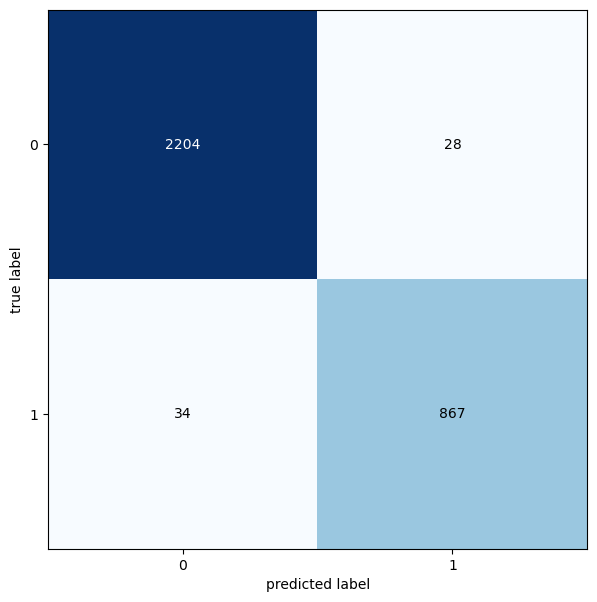

In [147]:
from torchmetrics import ConfusionMatrix
# plot_confusion_matrix will plot the metrix in a nicer way
from mlxtend.plotting import plot_confusion_matrix

model_0.eval()
test_loss, test_performance= 0, 0
with torch.inference_mode():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    # Predict for test data
    test_logits= model_0(X).squeeze()
    test_pred= torch.round(torch.sigmoid(test_logits))
    
    # Calculate test loss/accuracy
    test_loss+= loss_fn(test_logits, y)
    test_performance+= performance_fn(test_pred, y)

print(f"After training results: Test loss: {test_loss:.5f} Test {PERFORMANCE_MEASURE}: {test_performance*100:.2f}%")

confmat= ConfusionMatrix(task='binary')

# test_data.targets are the values we want to predict in the test dataloader
confmat_tensor= confmat(
  preds= test_pred.cpu(),
  target= targets_tensor_test.cpu())

# Plot the confusion matrix
fig, ax= plot_confusion_matrix(
  conf_mat= confmat_tensor.numpy(),
  figsize= (10, 7)
)


In [148]:
# DECISION SET: MODEL_NAME = Name of the file where saving model results
# DECISION SET: predictUP / predictDOWN

from pathlib import Path

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

target= "UP" if index_keep > 0 else "DOWN"

false_positives = confmat_tensor[0, 1].item()
true_positives = confmat_tensor[1, 1].item()
print(f"false_positives: {false_positives} true_positives: {true_positives}")

# Create path to the model
MODEL_NAME= f"2024-04-22-{TICKER}-predict{target}-dates20200101-20231231-in16-hid{HIDDEN_UNITS}-down{DOWN_PCTS_PREDICT[0]}-up{UP_PCTS_PREDICT[0]}-{PERFORMANCE_MEASURE}{test_performance*10000:.0f}pct-fp{false_positives}-tp{true_positives}.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(
  obj=model_0.state_dict(),
  f=MODEL_SAVE_PATH)

MODEL_NAME= f"2024-04-22-model-best-{TICKER}-predict{target}-dates20200101-20231231-in16-hid{HIDDEN_UNITS}-down{DOWN_PCTS_PREDICT[0]}-up{UP_PCTS_PREDICT[0]}-{PERFORMANCE_MEASURE}{test_performance*10000:.0f}pct-fp{false_positives}-tp{true_positives}.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(
    obj=best_model_state_dict, 
    f=MODEL_SAVE_PATH)


false_positives: 28 true_positives: 867


In [ ]:
# DECISION SET: StockModelBinaryV0(16, 12) Dimensions of the network

loaded_model_0 = StockModelBinaryV0(16, 12)
# Created a model from same class and since load_state_dict() is method from nn.Module it can be called to populate the state
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.to(device)

In [ ]:
loaded_model_0.eval()
test_loss, test_performance= 0, 0
with torch.inference_mode():
    for X, y in test_dataloader:
        X= X.to(device)
        y= y.to(device)
    
        # Predict for test data
        test_logits= loaded_model_0(X).squeeze()
        test_pred= torch.round(torch.sigmoid(test_logits))
        
        # Calculate test loss/accuracy
        test_loss+= loss_fn(test_logits, y)
        test_performance+= performance_fn(test_pred, y)

    test_loss /= len(test_dataloader)
    test_performance /= len(test_dataloader)

print(f"After loading results: Test loss: {test_loss:.5f} Test acc: {test_performance*100:.2f}%")


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary  


In [ ]:
summary(model_0, input_size=[len(signal_windows)])